# Projeto 2 - Ciência dos Dados

**Nome: Breno Marti**

**Nome: João Pedro Chacon Ruiz**

O trabalho do projeto 2 consiste na criação de um algoritmo que, a partir da fórmula de Bayes, possa prever resultados com base em condições passadas. Neste caso, o algoritmo deve prever a relevância, ou a falta dela, em tweets à respeito da quebra do recorde de velocidade pela Bugatti Chiron.

___
# Montando todo o Classificador Automático de Sentimento


## Preparando o ambiente no jupyter:

In [2]:
%%capture

#Instalando o tweepy
!pip install tweepy
!pip install emojis

In [3]:
import tweepy
import math
import os.path
import pandas as pd
import json
import numpy as np
from random import shuffle

___
## Autenticando no  Twitter

* Conta: @Pp37111695

In [4]:
'''
#Dados de autenticação do twitter:

#Coloque aqui o identificador da conta no twitter: @fulano

#leitura do arquivo no formato JSON
with open('auth.pass') as fp:    
    data = json.load(fp)

#Configurando a biblioteca. Não modificar
auth = tweepy.OAuthHandler(data['consumer_key'], data['consumer_secret'])
auth.set_access_token(data['access_token'], data['access_token_secret'])
'''

"\n#Dados de autenticação do twitter:\n\n#Coloque aqui o identificador da conta no twitter: @fulano\n\n#leitura do arquivo no formato JSON\nwith open('auth.pass') as fp:    \n    data = json.load(fp)\n\n#Configurando a biblioteca. Não modificar\nauth = tweepy.OAuthHandler(data['consumer_key'], data['consumer_secret'])\nauth.set_access_token(data['access_token'], data['access_token_secret'])\n"

___
## Etapas do projeto:

### Escolha de um produto e coleta das mensagens


In [5]:
#Produto escolhido:
produto = 'Bugatti'

#Quantidade mínima de mensagens capturadas:
n = 500
#Quantidade mínima de mensagens para a base de treinamento:
t = 300

#Filtro de língua, escolha uma na tabela ISO 639-1.
lang = 'pt'

Capturando os dados do twitter:

In [6]:
'''
#Cria um objeto para a captura
api = tweepy.API(auth)

#Inicia a captura, para mais detalhes: ver a documentação do tweepy
i = 1
msgs = []
for msg in tweepy.Cursor(api.search, q=produto, lang=lang, tweet_mode="extended").items():
    if (not msg.retweeted) and ('RT' not in msg.full_text):
        msgs.append(msg.full_text.lower())
        i += 1
    if i > n:
        break

#Embaralhando as mensagens para reduzir um possível viés
shuffle(msgs'
'''

'\n#Cria um objeto para a captura\napi = tweepy.API(auth)\n\n#Inicia a captura, para mais detalhes: ver a documentação do tweepy\ni = 1\nmsgs = []\nfor msg in tweepy.Cursor(api.search, q=produto, lang=lang, tweet_mode="extended").items():\n    if (not msg.retweeted) and (\'RT\' not in msg.full_text):\n        msgs.append(msg.full_text.lower())\n        i += 1\n    if i > n:\n        break\n\n#Embaralhando as mensagens para reduzir um possível viés\nshuffle(msgs\'\n'

Salvando os dados em uma planilha Excel:

In [7]:
'''
#Verifica se o arquivo não existe para não substituir um conjunto pronto
if not os.path.isfile('./{0}.xlsx'.format(produto)):
    
    #Abre o arquivo para escrita
    writer = pd.ExcelWriter('{0}.xlsx'.format(produto))

    #divide o conjunto de mensagens em duas planilhas
    dft = pd.DataFrame({'Treinamento' : pd.Series(msgs[:t])})
    dft.to_excel(excel_writer = writer, sheet_name = 'Treinamento', index = False)

    dfc = pd.DataFrame({'Teste' : pd.Series(msgs[t:])})
    dfc.to_excel(excel_writer = writer, sheet_name = 'Teste', index = False)

    #fecha o arquivo
    writer.save()
'''

"\n#Verifica se o arquivo não existe para não substituir um conjunto pronto\nif not os.path.isfile('./{0}.xlsx'.format(produto)):\n    \n    #Abre o arquivo para escrita\n    writer = pd.ExcelWriter('{0}.xlsx'.format(produto))\n\n    #divide o conjunto de mensagens em duas planilhas\n    dft = pd.DataFrame({'Treinamento' : pd.Series(msgs[:t])})\n    dft.to_excel(excel_writer = writer, sheet_name = 'Treinamento', index = False)\n\n    dfc = pd.DataFrame({'Teste' : pd.Series(msgs[t:])})\n    dfc.to_excel(excel_writer = writer, sheet_name = 'Teste', index = False)\n\n    #fecha o arquivo\n    writer.save()\n"

___
### Classificando as mensagens manualmente

Para que o classificador possa operar, é necessário que o mesmo tenha uma base previamente feita em que se possa apoiar. Tal base deve ser feita a mão dentro do próprio arquivo Excel criado anteriormente.

___
### Montando o Classificador Naive-Bayes

In [8]:
raw = pd.read_excel('Bugatti_treino.xlsx')
relevante_treino_raw = raw[raw['Relevância'] == 1]
nao_relevante_treino_raw = raw[raw["Relevância"] == 0]

#### Funções de limpeza de texto:


In [9]:
import re 

def cleanup(text):
    """
        Função de limpeza muito simples que troca alguns sinais básicos por espaços
    """
    punctuation = '[#@,!\()-.€":?;]' # Note que os sinais [] são delimitadores de um conjunto.
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, ' ', text)
    return text_subbed   

In [10]:
import emojis

In [11]:
def transform_emojis(text):
    clean = emojis.decode(text)
    return clean

In [12]:
l = ['\n','https','//t','co/']

#### Limpando e transformando os dataframes em séries para a análise:

In [13]:
list1 = []
for tweet in relevante_treino_raw['Treinamento']:
    texto = transform_emojis(tweet)
    list1.append(cleanup(texto))
    
relevante_treino = pd.Series(list1)

O código abaixo funciona analisando cada trecho da série à procura dos termos marcados na lista "l" e, assim que os encontra, os substitui por espaços vazios, efetivamente, deletando-os do texto. A vantagem deste é que pode-se procurar por lixos que são compostos por mais de um caractere, sem que se prejudique a estrutura dos tweets.

In [14]:
tweets_relevante_treino = relevante_treino.str.replace('|'.join(l),'',regex=True).str.strip()

In [15]:
list2 = []
for tweet in nao_relevante_treino_raw['Treinamento']:
    texto = transform_emojis(tweet)
    list2.append(cleanup(texto))
    
nao_relevante_treino = pd.Series(list2)

In [16]:
tweets_nao_relevante_treino = nao_relevante_treino.str.replace('|'.join(l),'',regex=True).str.strip()

In [17]:
list3 = []
for tweet in raw['Treinamento']:
    texto = transform_emojis(tweet)
    list3.append(cleanup(texto))
    
tudo = pd.Series(list3)

In [18]:
tweets_treino = tudo.str.replace('|'.join(l),'',regex=True).str.strip()

#### Contando o número de aparições de cada palavra :

In [19]:
list4 = []
for tweet in tweets_treino:
    list4 = list4 + tweet.split()

palavras_universo_treino = pd.Series(list4)

In [20]:
list5 = []
for tweet in tweets_relevante_treino:
    list5 = list5 + tweet.split()

palavras_relevantes_treino = pd.Series(list5)

In [21]:
list6 = []
for tweet in tweets_nao_relevante_treino:
    list6 = list6 + tweet.split()

palavras_nao_relevantes_treino = pd.Series(list6)

#### Frequência relativa de cada palavra:

In [22]:
palavras_universo_treino.value_counts(True)

bugatti            0.044511
de                 0.025549
a                  0.024750
o                  0.023752
que                0.014970
um                 0.014770
e                  0.013772
do                 0.013373
chiron             0.012974
não                0.012375
na                 0.010978
km/h               0.009182
carro              0.009182
490                0.007984
nome               0.007984
eu                 0.007784
é                  0.007784
com                0.007385
em                 0.006986
primeira           0.006587
mais               0.006587
seu                0.005988
gente              0.005190
letra              0.005190
para               0.005190
por                0.004990
da                 0.004790
velocidade         0.004790
recorde            0.004591
bananaobjeto       0.004591
                     ...   
bea                0.000200
vs                 0.000200
s15                0.000200
pzwnfmo3pn         0.000200
dirigir            0

In [23]:
palavras_relevantes_treino.value_counts(True)

bugatti         0.051213
o               0.037062
a               0.035714
de              0.035040
chiron          0.030323
km/h            0.025606
que             0.020889
490             0.020889
carro           0.018194
um              0.017520
do              0.015499
em              0.014825
mais            0.013477
velocidade      0.013477
recorde         0.012803
e               0.011456
é               0.010108
com             0.010108
não             0.009434
da              0.008760
300             0.007412
sport           0.006739
mph             0.006739
os              0.006065
chega           0.005391
super           0.005391
mundial         0.005391
para            0.004717
por             0.004717
500             0.004717
                  ...   
xboxgamepass    0.000674
7oy8lmcb74      0.000674
parabéns        0.000674
vida            0.000674
absurdo         0.000674
uol             0.000674
20lngpzvmw      0.000674
anlchcgric      0.000674
pauloramos1     0.000674


In [24]:
palavras_nao_relevantes_treino.value_counts(True)

bugatti                            0.041690
de                                 0.021554
a                                  0.020136
o                                  0.018151
e                                  0.014748
na                                 0.013897
não                                0.013613
um                                 0.013613
do                                 0.012479
que                                0.012479
nome                               0.011061
eu                                 0.009075
primeira                           0.009075
seu                                0.008225
letra                              0.007374
gente                              0.007090
é                                  0.006807
bananaobjeto                       0.006523
olhar                              0.006239
vamos                              0.006239
vale                               0.006239
jogar                              0.006239
com                             

In [25]:
#probabilidade de uma palavra ser relevante na planilha de treino
P_relevante = palavras_relevantes_treino.size/palavras_universo_treino.size
P_relevante

0.2962075848303393

In [26]:
#probabilidade de uma palavra ser relevante na planilha de treino
P_nao_relevante = palavras_nao_relevantes_treino.size/palavras_universo_treino.size
P_nao_relevante

0.7037924151696606

___
## Verificando a performance

Agora, o algoritmo será aplicado para a base de testes do Excel, para que se possa prosseguir com a análise.

In [27]:
#Lendo os arquivos de Excel da base de testes
raw2 = pd.read_excel('Bugatti_teste.xlsx')
relevante_teste_raw2 = raw2[raw2['Relevância'] == 1]
nao_relevante_teste_raw2 = raw2[raw2["Relevância"] == 0]

In [28]:
# Rodando as funções de limpeza para todas a séries a serem criadas
lista1 = []
for tweet in relevante_teste_raw2['Teste']:
    texto = transform_emojis(tweet)
    lista1.append(cleanup(texto))
    
tweets_relevante_teste = pd.Series(lista1)
tweets_relevante_teste = tweets_relevante_teste.str.replace('|'.join(l),'',regex=True).str.strip()

In [29]:
lista2 = []
for tweet in nao_relevante_teste_raw2['Teste']:
    texto = transform_emojis(tweet)
    lista2.append(cleanup(texto))
    
tweets_nao_relevante_teste = pd.Series(lista2)
tweets_nao_relevante_teste = tweets_nao_relevante_teste.str.replace('|'.join(l),'',regex=True).str.strip()

In [30]:
lista3 = []
for tweet in raw2['Teste']:
    texto = transform_emojis(tweet)
    lista3.append(cleanup(texto))
    
tweets_universo_teste = pd.Series(lista3)
tweets_universo_teste = tweets_universo_teste.str.replace('|'.join(l),'',regex=True).str.strip()

In [31]:
lista4 = []
for tweet in tweets_universo_teste:
    lista4 = lista4 + tweet.split()

palavras_universo_teste = pd.Series(lista4)
palavras_universo_teste.value_counts()

bugatti                     137
a                            92
de                           73
o                            66
e                            63
que                          51
do                           51
chiron                       47
não                          43
km/h                         42
um                           39
é                            37
490                          32
carro                        31
com                          31
recorde                      28
na                           26
uma                          23
nome                         21
eu                           21
em                           20
mais                         19
seu                          18
primeira                     18
300                          17
no                           17
pra                          17
bananaobjeto                 17
se                           16
da                           16
                           ... 
amor    

In [32]:
lista5 = []
for tweet in tweets_relevante_teste:
    lista5 = lista5 + tweet.split()

palavras_relevantes_teste = pd.Series(lista5)
freq_rel_palavras_relevantes_teste = palavras_relevantes_teste.value_counts(True)

In [33]:
lista6 = []
for tweet in tweets_nao_relevante_teste:
    lista6 = lista6 + tweet.split()

palavras_nao_relevantes_teste = pd.Series(lista6)
freq_rel_palavras_nao_relevantes_teste = palavras_nao_relevantes_teste.value_counts(True)

### Montando o Classificardor Naive Bayes

Agora, para que se monte o classificador em sí, é preciso montar as suas partes.

> Montagem das probabilidades de cada tweet ser relevante ou não relevante

In [34]:
num_palavras_teste = palavras_relevantes_teste.size + palavras_nao_relevantes_teste.size
num_palavras_teste

3416

In [35]:
#probabilidade do tweet ser relevante
prob_relevante_teste = tweets_relevante_teste.size / tweets_universo_teste.size
prob_relevante_teste

0.38

In [36]:
#probabilidade do tweet não ser relevante
prob_nao_relevante_teste = tweets_nao_relevante_teste.size / tweets_universo_teste.size
prob_nao_relevante_teste

0.62

### Como o classificador funcionará:

O classificador será montado a partir de duas funções, que, ao serem chamadas dentro de um loop criado por meio de um "for", calcularão as probabilidades que cada tweet tem de ser relevante ou não relevante. Para isso, uma função será chamada de **irrelevancia_tweet_individual** e a outra de **relevancia_tweet_individual**. No loop, as duas receberão como input o mesmo tweet e, a partir de seus parâmetros respectivos, retornarão diferentes probabilidades deste mesmo ser relevante ou não.

> Setting das constantes do Laplace Smoothing

In [37]:
# Settando as constantes que serão usadas para aplicar o laplace Smoothing
fundo = 1e-4 
total_palavras = 3416

> Montagem do corpo das duas funções a serem usadas.

In [38]:

# Construção do corpo da funcao de irrelevância
def irrelevancia_tweet_individual(tweet):
    
    # Transforma o tweet que é puramente str em uma lista com termos que são str
    a_ser_analisado = tweet.split()
     
    # Estabelesce o valor da probabilidade do tweet ser relevante
    probabilidade_irrelevancia = 1
    
    # Estabelesce o valor da probabilidade do tweet ser irrelevante
    for palavra in a_ser_analisado:
        
        if palavra in freq_rel_palavras_nao_relevantes_teste:
        
            probabilidade_irrelevancia = probabilidade_irrelevancia*(freq_rel_palavras_nao_relevantes_teste[palavra]*palavras_nao_relevantes_teste.size+fundo)  / (palavras_nao_relevantes_teste.size+fundo*total_palavras)*1000
            
        else:
                       
            probabilidade_irrelevancia = probabilidade_irrelevancia*(fundo) / (palavras_nao_relevantes_teste.size+fundo*total_palavras)*1000
            
    probabilidade_irrelevancia = probabilidade_irrelevancia * prob_nao_relevante_teste
    probabilidade_irrelevancia = math.log(probabilidade_irrelevancia)
    
    return probabilidade_irrelevancia


# Construção do corpo da função relevância:
def relevancia_tweet_individual(tweet):
    
    # Transforma o tweet que é puramente str em uma lista com termos que são str
    a_ser_analisado = tweet.split()
    
    # Estabelesce o valor da probabilidade do tweet ser relevante
    probabilidade_relevancia = 1
    
    # Estabelesce o valor da probabilidade do tweet ser relevante.
    for palavra in a_ser_analisado:
        
        if palavra in freq_rel_palavras_relevantes_teste:
            
            probabilidade_relevancia = probabilidade_relevancia*(freq_rel_palavras_relevantes_teste[palavra]*palavras_relevantes_teste.size+fundo) / 1000*(palavras_relevantes_teste.size+fundo*total_palavras)  
            
        else:
            
            probabilidade_relevancia = probabilidade_relevancia*(fundo) / 1000*(palavras_relevantes_teste.size+fundo*total_palavras) 
    
    # Ajuste final na probabilidade e uso de função logaritmo para que se evite a perda de informações 
    probabilidade_relevancia = probabilidade_relevancia * prob_relevante_teste
    probabilidade_relevancia = math.log(probabilidade_relevancia)
    
    return probabilidade_relevancia

> Criação do loop que chama as duas funções a fim de analisar seus retornos para cada tweet

In [41]:

# Criação do loop que chama as funções para analisar todos os tweets da base de testes

lista_resultados_finais = []

# Cria o loop
for tweet in tweets_universo_teste:
    
    #Chama as funções e da um veredito baseado na relação entre o retorno das duas
    if relevancia_tweet_individual(tweet) > irrelevancia_tweet_individual(tweet):
           lista_resultados_finais.append(1)
            
    if relevancia_tweet_individual(tweet) < irrelevancia_tweet_individual(tweet):
        lista_resultados_finais.append(0)
    

___
>Depois disso, é passado um programa que lê as respostas dadas pelo algoritmo classificador e as compara com as respostas manuais feitas à mão.

In [44]:
# Código que compila todos os resultados

i = 0
verdadeiros_positivos = 0
falsos_positivos = 0
verdadeiros_negativos = 0
falsos_negativos = 0

for tweet in raw2['Relevância']:
    if tweet == lista_resultados_finais[i] and lista_resultados_finais[i] == 1:
        verdadeiros_positivos += 1
    
    if tweet == lista_resultados_finais[i] and lista_resultados_finais[i] == 0:
        verdadeiros_negativos += 1
    
    if tweet != lista_resultados_finais[i] and lista_resultados_finais[i] == 1:
        falso_positivos += 1
        
    if tweet != lista_resultados_finais[i] and v[i] == 0:
        falsos_negativos += 1
        
    i += 1
        
print("Número de vardadeiros positivos: ",verdadeiros_positivos)
print("Número de falsos positivos: ",falsos_positivos)
print("Número de verdadeiros negativos: ",verdadeiros_negativos)
print("Número de falsos negativos: ",falsos_negativos)

Número de vardadeiros positivos:  76
Número de falsos positivos:  0
Número de verdadeiros negativos:  124
Número de falsos negativos:  0


In [45]:
valores_relevancia = []
valores_irrelevancia = [] 

for tweet in tweets_universo_teste:
    valores_relevancia.append(relevancia_tweet_individual(tweet))
    valores_irrelevancia.append(irrelevancia_tweet_individual(tweet))
    

In [46]:
i=0

lista_magnitude = []

while i<len(valores_relevancia):
    
    if abs(valores_relevancia[i]) / abs(valores_irrelevancia[i]) > 1.5:
        lista_magnitude.append("Muito Irrelevante")
            
    if  abs(valores_relevancia[i]) / abs(valores_irrelevancia[i]) > 1 and abs(valores_relevancia[i]) / abs(valores_irrelevancia[i]) < 1.5:
        lista_magnitude.append("Pouco Irrelevante")
        
    if abs(valores_relevancia[i]) / abs(valores_irrelevancia[i])  < 1 and abs(valores_relevancia[i])/ abs(valores_irrelevancia[i]) >0.66:
        lista_magnitude.append("Pouco Relevânte")
            
    if abs(valores_relevancia[i]) / abs(valores_irrelevancia[i]) <0.66:
        lista_magnitude.append("Muito Relevânte")
    i += 1

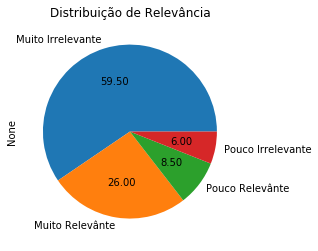

In [48]:
grafico = pd.Series(lista_magnitude).value_counts()
grafico.plot(kind="pie",title="Distribuição de Relevância", autopct="%0.2f", legend=False)

___
## Concluindo

> 1: Tendo em vista todo o trabalho desenvolvido, pode ser concluido que, neste caso o classificador Naive Bayes demonstrou resultados surpreendentes. Estes resultados evidenciam características não notadas à primeira vista. Um exemplo disso é a disparidade entre os tweets relevantes e os irrelevantes em sua forma, dado que houve uma prevalência de resultados muito relevantes e muito irrelevantes, aliado à falta de falsos positivos e falsos negativos.

> 2: Como exercício de autocrítica, seria possível ter tido proveito de uma limpeza de texto que padronizasse modos de se dizer uma mesma palavra, por exemplo: A palavra voce, no código atual, é tratada diferentemente da palavra vc, porem ambas indicam a mesma mensagem. Uma função que considerasse exemplos como esse como iguais aumentariam a precisão da análise, dado que, assim, o classificador poderia analisar mais a mensagem em sí do que simplesmente as palavras usadas.

> 3: Sabendo, agora, como o classificador Naive Bayes funciona, é possível que se pense em outros usos úteis para o mesmo. Um deles, em especial, pode englobar o mercado financeiro, dado que, é possível, a partir da análises das medidas tomadas nos ultimos tempos por empresas ou governos, prever com relativa precisão como se dará a evolução do valor de certos ativos.

> 4: Como uma proposta de melhoria, seria possível criar uma função que limpa os textos das chamadas "Stopwords" que, em sua maioria, são conectivos que não expressam valores significativos para o classificador. Essa função poderia passar pelo texto em um loop, procuranto por stopwords determinadas em seus parâmetros, como "até", "desde" ou "que", as deletando assim que as encontrasse. Isso aumentaria a pureza do texto a ser analisado e, consequentemente, aumentaria a precisão do classificador Naive Bayes. Mais informações estão disponíveis em: https://en.wikipedia.org/wiki/Stop_words, https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

> 5: Não é possível usar o classificador para que se produza uma base de dados pois o mesmo não consideram a ordem das palavras. Dado que o emprego do Naive Bayes usa o produto de muitos termos para calcular o resultado, pode-se perceber que a ordem dos termos não altera o resultado, como em qualquer multiplicação. Logo, se o classificador não considera ordem, criar uma base de dados a partir dele é impossível pois a mesma seria ininteligível, sendo composta por uma mistura aleatória de palavras tratadas como relevante e irrelevantes.


# Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**